\begin{equation}
	\begin{aligned}
		V_i(x) \quad  = \quad \max_{y} \quad & U\big(x,y,\xi_i\big) + \beta \sum_{j=1}^{m} P_{ij}V_j(x') \\
		\textrm{s.t.} \quad & y \in \Gamma(x) \\
		\quad & x'=h(x,y,\xi_j)
	\end{aligned}
\end{equation}

In [1]:
using  Plots, LinearAlgebra, Optim, DataFrames, StatFiles, Distributions, Roots, Random, Interpolations, BenchmarkTools
using PGFPlotsX

In [2]:
function DDP(R, Q, Grid, IG, β; ϵ=10^-6) 
    ns = size(R)[1] # number of shocks
    gs = size(R)[2] # grid size
    sup = 1
    One = ones(gs) # 1 vector
    V = repeat(IG.(Grid), 1, ns)' # Value function matrix (Initial guess)
    g = zeros(ns,gs)
    Vc = copy(V)
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        for i in 1:ns # T_operator for V1 to Vns
            V[i,:], Argmax = findmax(R[i,:,:] .+ sum([β*Q[i,j]*One*V[j,:]' for j in 1:ns]), dims=2)
            for a in 1:gs
                g[i,a] = Argmax[a][2] # Policy function
            end
        end
        sup = sum((V .- Vc).^2)
        Vc = copy(V)
    end
    P = zeros(ns,gs)
    for i in 1:ns
        for j in 1:gs
            P[i,j] = Grid[Int(g[i,j])]
        end
    end
    return V, P
end

DDP (generic function with 1 method)

In [3]:
function return_function(r, σ, w, S, Grid)
    ns = length(S)
    gs = length(Grid)
    R = zeros(ns, gs, gs)
    Rr(a,s,a_prim) = (((1+r)*a + w*s - a_prim)^(1-σ)) / (1-σ)
    for i in 1:ns
        for j in 1:gs
            for k in 1:gs
                R[i,j,k] = ((1+r)*Grid[j] + w*S[i] - Grid[k])>0 ? Rr(Grid[j],S[i],Grid[k]) : -100000
            end
        end
    end
    return R
end

return_function (generic function with 1 method)

In [4]:
function ab_LogNormal(mu, sig)
    a(b) = log(mu)-b^2/2
    f(b) = sig^2 - (exp(b^2)-1)*(exp(2*a(b) + b^2))
    b_star = find_zero(f, sig)
    a_star = a(b_star)
    return a_star, b_star
end

ab_LogNormal (generic function with 1 method)

In [5]:
σ = 0.8
w = 1
β = 0.90
l = 100
r = 0.07
ns = 100
Grid = range(0, 40, l)
a, b = ab_LogNormal(4, 2)
S = rand(LogNormal(a,b),ns)
R = return_function(r, σ, w, S, Grid)
Q = ones(ns,ns)./ns
IG(x) = √x
Value_function, Policy_function = DDP(R, Q, Grid, IG, β);
Value_function_mean = mean(Value_function, dims=1)'
Policy_function_mean = mean(Policy_function, dims=1)';

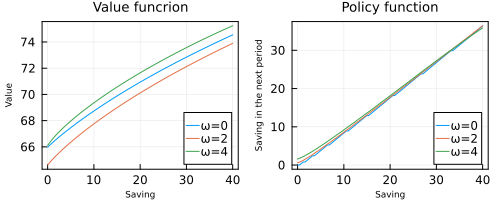

In [6]:
p1 = plot(legend_position=:bottomright)
xlabel!("Saving")
ylabel!("Value")
p2 = plot(legend_position=:bottomright)
xlabel!("Saving")
ylabel!("Saving in the next period")
for ω in [0, 2, 4]
    a, b = ab_LogNormal(4, ω)
    S = rand(LogNormal(a,b),ns)
    R = return_function(r, σ, w, S, Grid)
    Value_function, Policy_function = DDP(R, Q, Grid, IG, β);
    Value_function_mean = mean(Value_function, dims=1)'
    Policy_function_mean = mean(Policy_function, dims=1)';
    plot!(p1, Grid, Value_function_mean, title = "Value funcrion", label="ω=$(ω)", titlefontsize=9, guidefontsize=6)
    plot!(p2, Grid, Policy_function_mean, title = "Policy function", label="ω=$(ω)", titlefontsize=9, guidefontsize=6)
end
plots = []
push!(plots,p1)
push!(plots,p2)
plot(plots..., framestyle = :box, size = (500, 200))